In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 25.9MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 16.8MB/s 


In [2]:
#!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1 -O erm.zip

--2021-03-03 15:53:03--  https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1
Resolving unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)... 40.108.195.27
Connecting to unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)|40.108.195.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9amJSa2JsemUyRWc [following]
--2021-03-03 15:53:04--  https://unirioja-my.sharepoint.com/personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9amJSa2JsemUyRWc
Reusing existing connection to unirioja-my.share

In [3]:
!unzip erm.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: erm/train/no/anonymized_1873542_fakeB.jpg  
  inflating: erm/train/no/anonymized_887511_fakeB.jpg  
  inflating: erm/train/no/anonymized_1351887_fakeB.jpg  
  inflating: erm/train/no/anonymized_1099051_fakeB.jpg  
  inflating: erm/train/no/anonymized_448602_fakeB.jpg  
  inflating: erm/train/no/anonymized_852019_fakeB.jpg  
  inflating: erm/train/no/anonymized_169973_fakeB.jpg  
  inflating: erm/train/no/anonymized_1241994_fakeB.jpg  
  inflating: erm/train/no/anonymized_1898489_fakeB.jpg  
  inflating: erm/train/no/anonymized_160483_fakeB.jpg  
  inflating: erm/train/no/anonymized_593874_fakeB.jpg  
  inflating: erm/train/no/anonymized_359235_fakeB.jpg  
  inflating: erm/train/no/anonymized_782889_fakeB.jpg  
  inflating: erm/train/no/anonymized_324102_fakeB.jpg  
  inflating: erm/train/no/anonymized_532397_fakeB.jpg  
  inflating: erm/train/no/anonymized_263513_fakeB.jpg  
  inflating: erm/train/no/anonymized_1

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('erm/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest36')
]

In [9]:
import timm
timm.list_models('*resnest26*')

['resnest26d', 'resnest269e']

In [10]:
learn = timm_learner(dls512, 'resnest26d',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

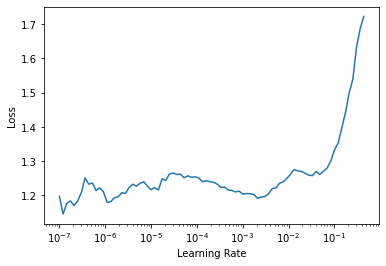

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.276498,1.014916,0.592055,0.571429,0.713846,00:59


Better model found at epoch 0 with valid_loss value: 1.0149157047271729.


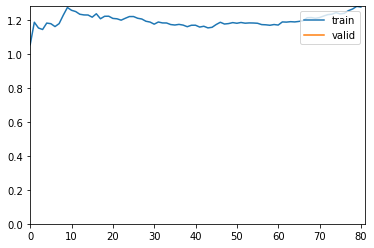

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.977451,0.859300,0.608098,0.670823,0.413846,01:05
1,0.899197,0.844901,0.608862,0.674242,0.410769,01:03
2,0.785391,0.715619,0.621849,0.623211,0.603077,01:03
3,0.718506,0.698148,0.637892,0.735294,0.423077,01:02
4,0.658135,0.646985,0.653170,0.714912,0.501538,01:03
5,0.611143,0.682469,0.640947,0.736842,0.430769,01:02
6,0.588906,0.613711,0.673033,0.711832,0.573846,01:02
7,0.551793,0.653490,0.653170,0.750000,0.452308,01:03
8,0.536076,0.617122,0.673797,0.746137,0.520000,01:02
9,0.529670,0.627112,0.667685,0.747126,0.500000,01:03


Better model found at epoch 0 with valid_loss value: 0.8593000173568726.


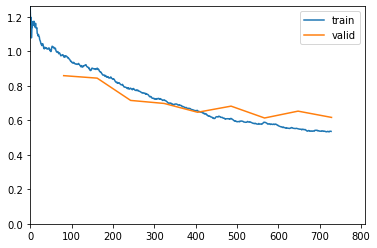

Better model found at epoch 1 with valid_loss value: 0.8449013233184814.
Better model found at epoch 2 with valid_loss value: 0.7156188488006592.
Better model found at epoch 3 with valid_loss value: 0.6981480717658997.
Better model found at epoch 4 with valid_loss value: 0.646984875202179.
Better model found at epoch 6 with valid_loss value: 0.6137110590934753.
No improvement since epoch 6: early stopping


In [11]:
learn.fine_tune(10,base_lr=1e-3)

In [12]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

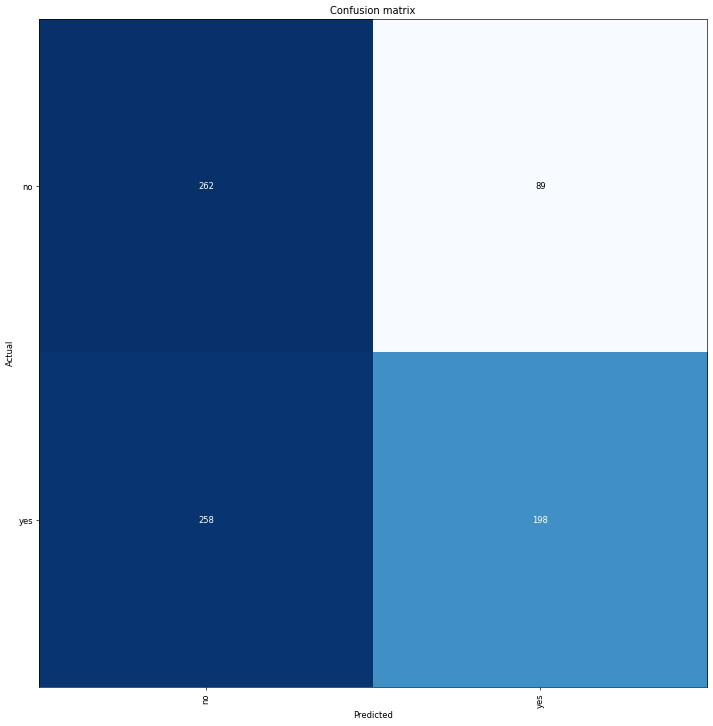

In [13]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [14]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5700123906135559.


(#4) [0.7406512498855591,0.5700123906135559,0.6898954703832753,0.4342105263157895]

In [15]:
learn.export(fname='resnest26.pkl')